In [2]:
from pathlib import Path

import cv2
import numpy as np
import IPython
import torch 

In [2]:
!wget https://github.com/astaileyyoung/CineFace/raw/main/research/data/face_detection_yunet_2023mar.onnx

--2024-11-14 16:47:34--  https://github.com/astaileyyoung/CineFace/raw/main/research/data/face_detection_yunet_2023mar.onnx
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/astaileyyoung/CineFace/main/research/data/face_detection_yunet_2023mar.onnx [following]
--2024-11-14 16:47:36--  https://raw.githubusercontent.com/astaileyyoung/CineFace/main/research/data/face_detection_yunet_2023mar.onnx
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 232589 (227K) [application/octet-stream]
Saving to: ‘face_detection_yunet_2023mar.onnx.3’

face_detection_yune 100%[===================>] 227.14K  --.-KB/s    

In [3]:
class FaceDetectorYunet():
    def __init__(self,
                  model_path='./face_detection_yunet_2023mar.onnx',
                  img_size=(300, 300),
                  threshold=0.5):
        self.model_path = model_path
        self.img_size = img_size
        self.fd = cv2.FaceDetectorYN_create(str(model_path),
                                            "",
                                            img_size,
                                            score_threshold=threshold)

    def draw_faces(self,
                   image,
                   faces,
                   draw_landmarks=False,
                   show_confidence=False):
        for face in faces:
            color = (0, 0, 255)
            thickness = 2
            cv2.rectangle(image, (face['x1'], face['y1']), (face['x2'], face['y2']), color, thickness, cv2.LINE_AA)

            if draw_landmarks:
                landmarks = face['landmarks']
                for landmark in landmarks:
                    radius = 5
                    thickness = -1
                    cv2.circle(image, landmark, radius, color, thickness, cv2.LINE_AA)

            if show_confidence:
                confidence = face['confidence']
                confidence = "{:.2f}".format(confidence)
                position = (face['x1'], face['y1'] - 10)
                font = cv2.FONT_HERSHEY_SIMPLEX
                scale = 0.5
                thickness = 2
                cv2.putText(image, confidence, position, font, scale, color, thickness, cv2.LINE_AA)
        return image

    def scale_coords(self, image, prediction):
        ih, iw = image.shape[:2]
        rw, rh = self.img_size
        a = np.array([
                (prediction['x1'], prediction['y1']),
                (prediction['x1'] + prediction['x2'], prediction['y1'] + prediction['y2'])
                    ])
        b = np.array([iw/rw, ih/rh])
        c = a * b
        prediction['img_width'] = iw
        prediction['img_height'] = ih
        prediction['x1'] = int(c[0,0].round())
        prediction['x2'] = int(c[1,0].round())
        prediction['y1'] = int(c[0,1].round())
        prediction['y2'] = int(c[1,1].round())
        prediction['face_width'] = (c[1,0] - c[0,0])
        prediction['face_height'] = (c[1,1] - c[0,1])
        # prediction['face_width'] = prediction['x2'] - prediction['x1']
        # prediction['face_height'] = prediction['y2'] - prediction['y1']
        prediction['area'] = prediction['face_width'] * prediction['face_height']
        prediction['pct_of_frame'] = prediction['area']/(prediction['img_width'] * prediction['img_height'])
        return prediction

    def detect(self, image):
        if isinstance(image, str):
            image = cv2.imread(str(image))
        img = cv2.cvtColor(image, cv2.COLOR_BGRA2BGR)
        img = cv2.resize(img, self.img_size)
        self.fd.setInputSize(self.img_size)
        _, faces = self.fd.detect(img)
        if faces is None:
            return None
        else:
            predictions = self.parse_predictions(image, faces)
            return predictions

    def parse_predictions(self,
                          image,
                          faces):
        data = []
        for num, face in enumerate(list(faces)):
            x1, y1, x2, y2 = list(map(int, face[:4]))
            landmarks = list(map(int, face[4:len(face)-1]))
            landmarks = np.array_split(landmarks, len(landmarks) / 2)
            positions = ['left_eye', 'right_eye', 'nose', 'right_mouth', 'left_mouth']
            landmarks = {positions[num]: x.tolist() for num, x in enumerate(landmarks)}
            confidence = face[-1]
            datum = {'x1': x1,
                     'y1': y1,
                     'x2': x2,
                     'y2': y2,
                     'face_num': num,
                     'landmarks': landmarks,
                     'confidence': confidence,
                     'model': 'yunet'}
            d = self.scale_coords(image, datum)
            data.append(d)
        return data


In [4]:
def show_image(image):
    _, ret = cv2.imencode('.jpg', image)
    i = IPython.display.Image(data=ret)
    IPython.display.display(i)

In [5]:
def show_by_name(name):
    fp = Path('../test_images').joinpath(name)
    img = cv2.imread(str(fp))
    show_image(img)

In [6]:
fd = FaceDetectorYunet()

### Testing out Yunet on multiple frames 

torch.Size([38, 3, 224, 224])


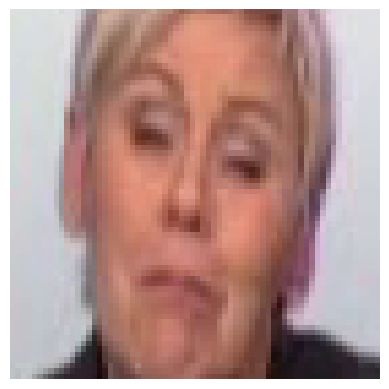

Emotion: sad


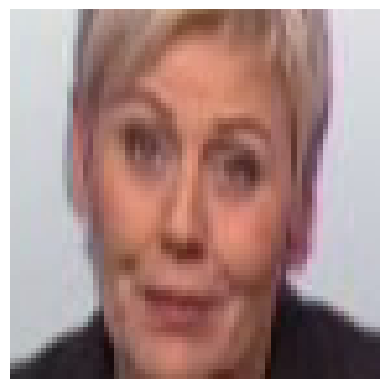

Emotion: neutral


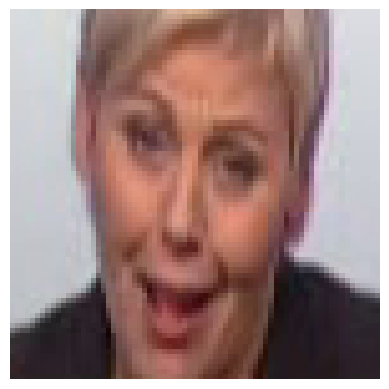

Emotion: angry


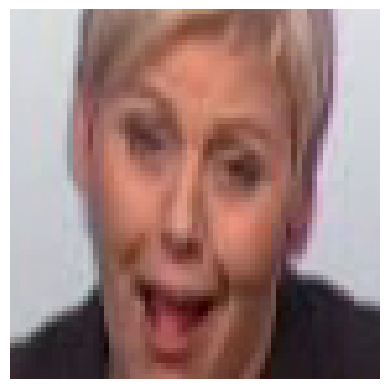

Emotion: surprise


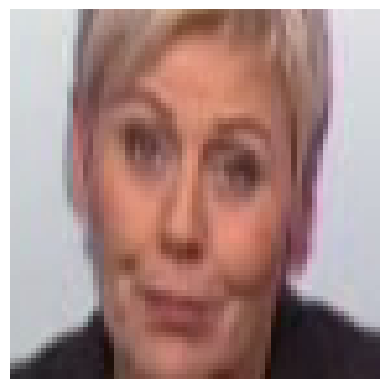

Emotion: neutral


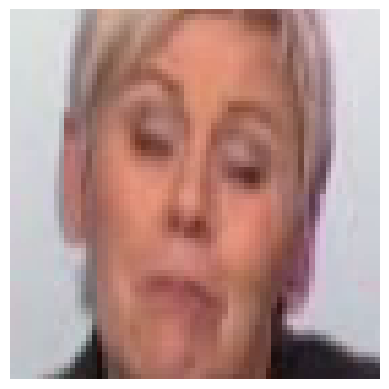

Emotion: fear


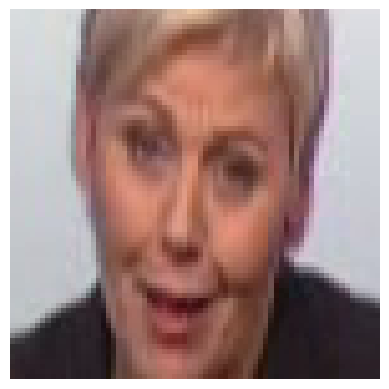

Emotion: surprise


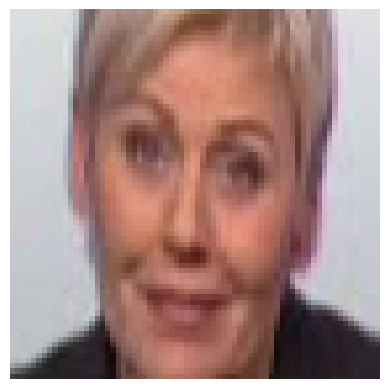

Emotion: happy


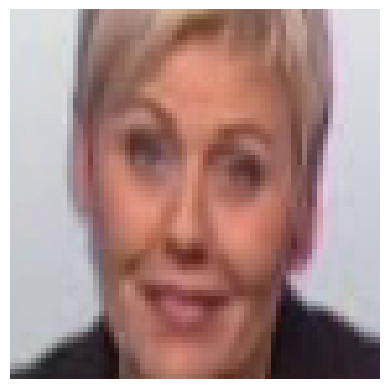

Emotion: happy


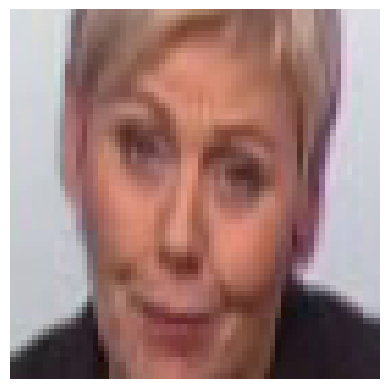

Emotion: fear


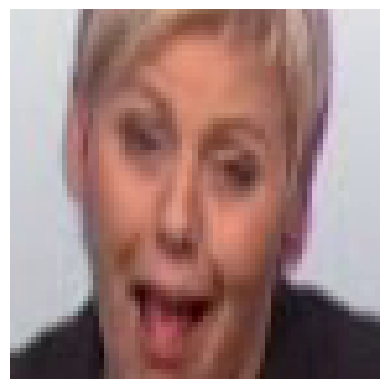

Emotion: angry


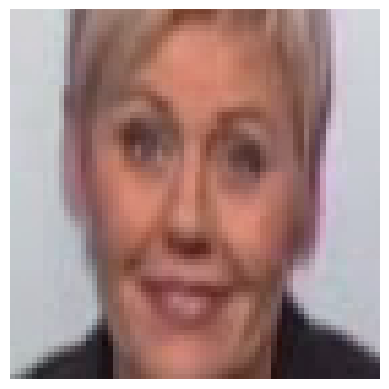

Emotion: happy


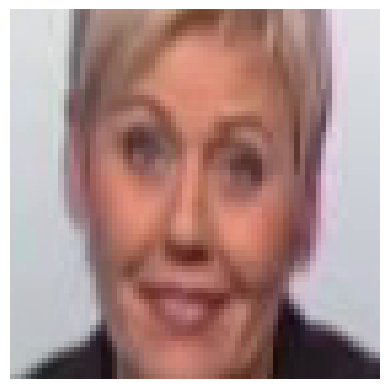

Emotion: happy


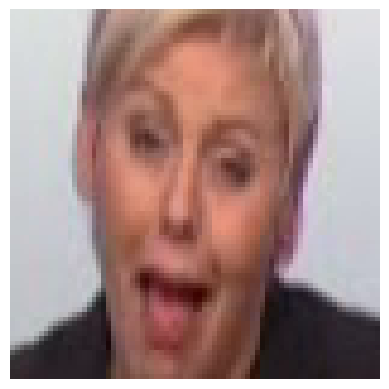

Emotion: angry


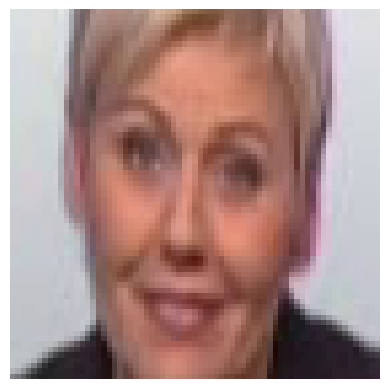

Emotion: happy


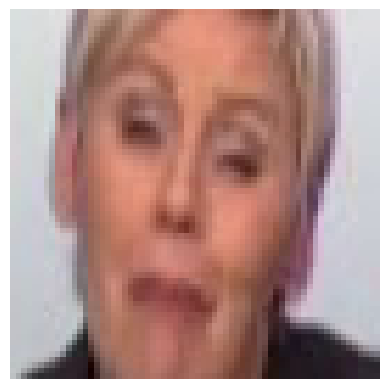

Emotion: angry


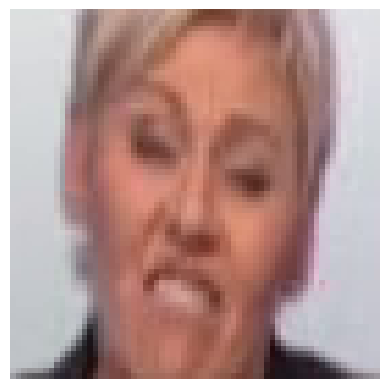

Emotion: angry


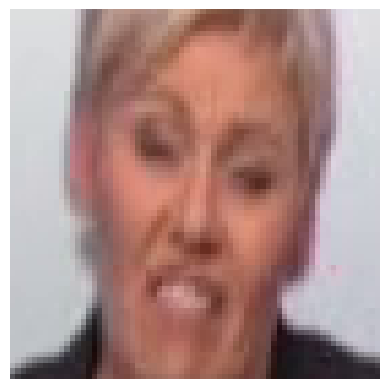

Emotion: angry


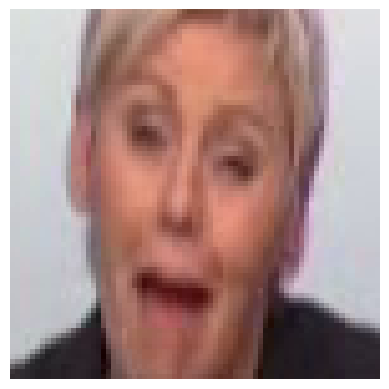

Emotion: happy


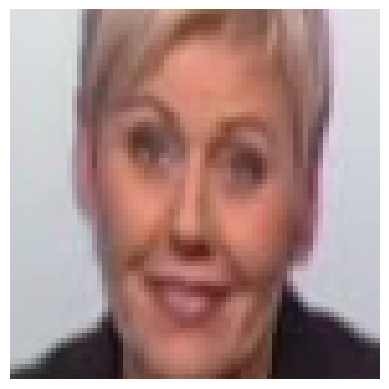

Emotion: happy


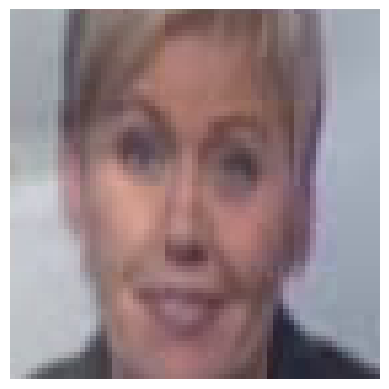

Emotion: happy


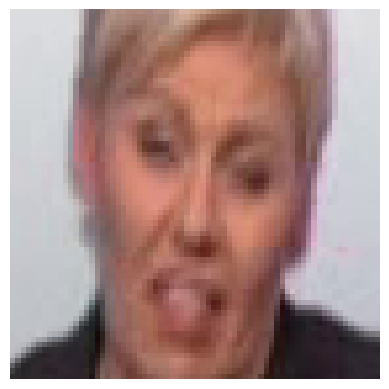

Emotion: angry


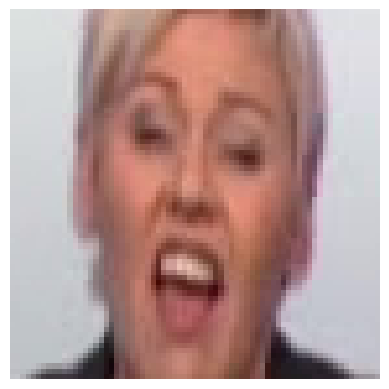

Emotion: angry


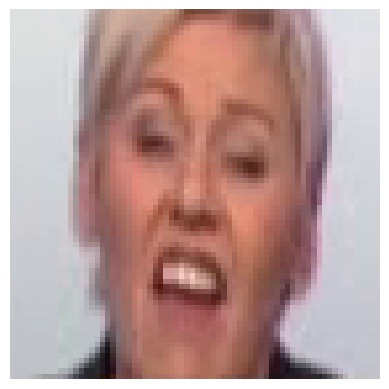

Emotion: fear


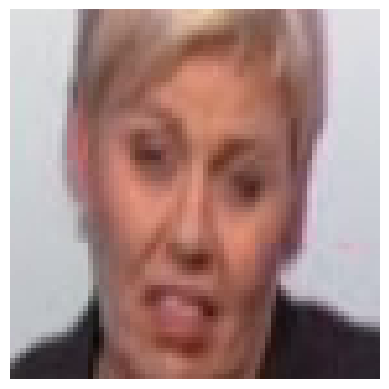

Emotion: angry


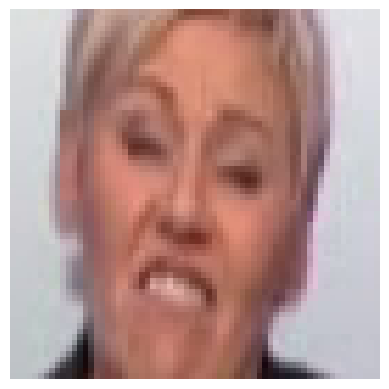

Emotion: fear


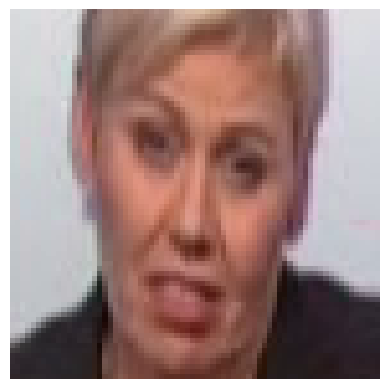

Emotion: sad


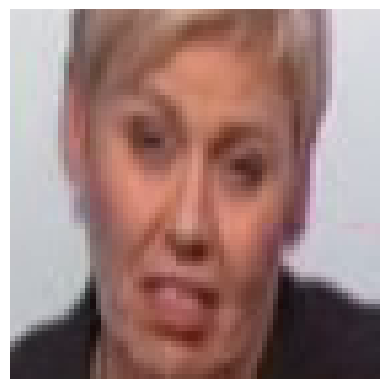

Emotion: angry


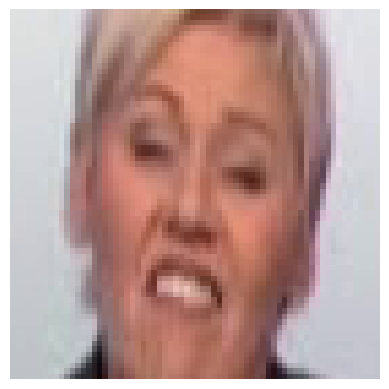

Emotion: angry


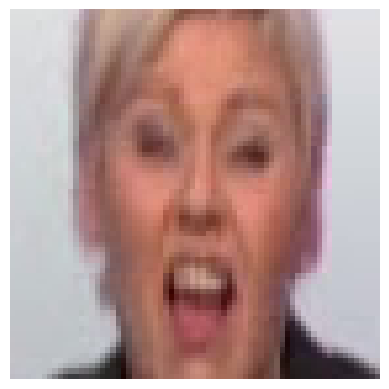

Emotion: angry


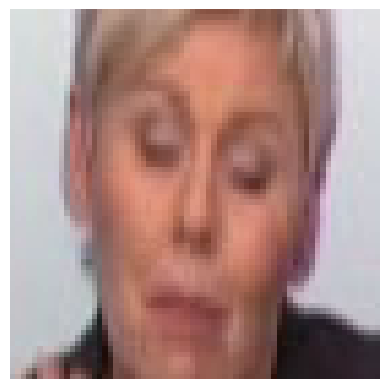

Emotion: sad


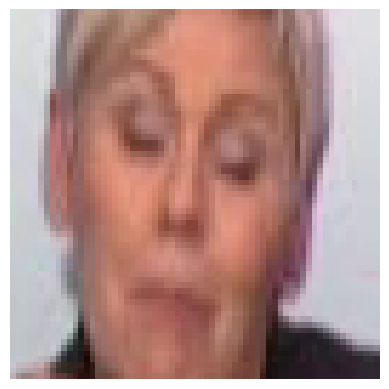

Emotion: angry


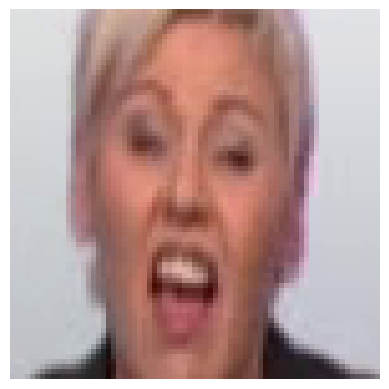

Emotion: angry


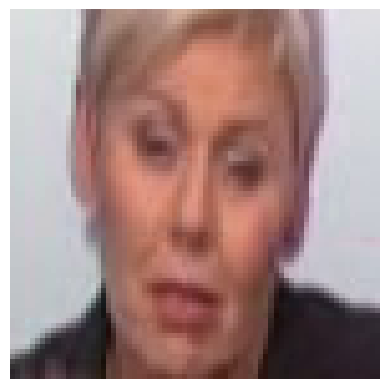

Emotion: fear


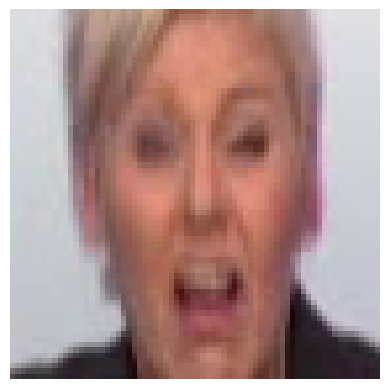

Emotion: angry


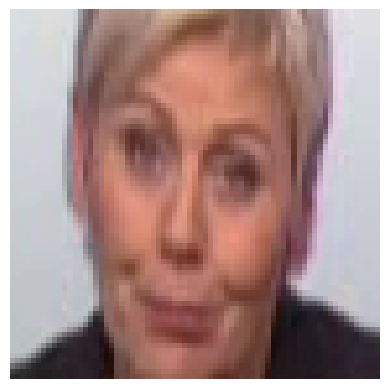

Emotion: neutral


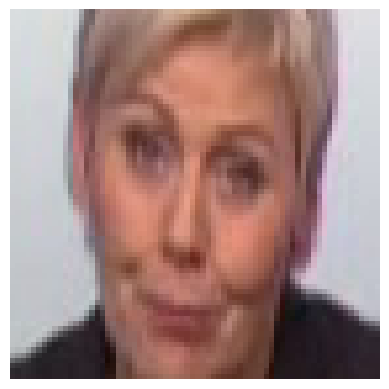

Emotion: neutral


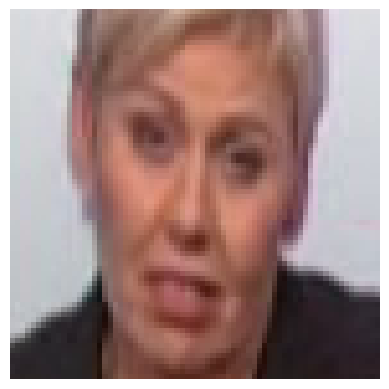

Emotion: sad
torch.Size([38, 768])


In [7]:
import os 
from torchvision import transforms
import os
from torchvision import transforms
import matplotlib.pyplot as plt

from PIL import Image
dir = '/Users/tannicholas/PHOENIX-2014-T-release-v3/PHOENIX-2014-T/features/fullFrame-210x260px/train/01December_2011_Thursday_tagesschau-3479'
image_paths = os.listdir(dir)
compiled_faces = []
plots = []
# PyTorch transformation to resize and convert to tensor
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224))
])
for path in image_paths: 
    actual_path = os.path.join(dir, path)
    
    # Load the image

    img = Image.open(actual_path).convert("RGB")  # Ensures image is in RGB format
    img_width, img_height = img.size
    img = np.array(img)
    # Detect faces
    faces = fd.detect(img)  # Assuming fd.detect() is your face detector
    
    
    # Always keep the face with the highest bounding box (lower on the image)
    if len(faces) > 1:
        faces = [min(faces, key=lambda x: x['y2'])]
        
    # Proceed if any face is detected
    if faces:
        face = faces[0]
        x1, y1, x2, y2 = face['x1'], face['y1'], face['x2'], face['y2']
        # Calculate width and height of the bounding box
        width = x2 - x1
        height = y2 - y1

        # Determine the size of the square side (maximum of width and height)
        side_length = max(width, height)

        # Calculate the center of the original bounding box
        center_x = x1 + width // 2
        center_y = y1 + height // 2

        # Adjust the bounding box to make it a square, centered around the original box
        new_x1 = center_x - side_length // 2
        new_y1 = center_y - side_length // 2
        new_x2 = new_x1 + side_length
        new_y2 = new_y1 + side_length

        # Ensure the new bounding box stays within the image boundaries
        new_x1 = max(0, new_x1)
        new_y1 = max(0, new_y1)
        new_x2 = min(img_width, new_x2)
        new_y2 = min(img_height, new_y2)
        
        # Crop the face from the image
        cropped_face = img[new_y1:new_y2, new_x1:new_x2]
        plots.append(cropped_face)
        # Convert the cropped face to a tensor
        face_tensor = transform(cropped_face) ## need to convert back to PIL image after cropping
        compiled_faces.append(face_tensor)
        
# Load model directly

id2label = {
    0: "angry",
    1: "disgust",
    2: "fear",
    3: "happy",
    4: "neutral",
    5: "sad",
    6: "surprise"
  }

from transformers import AutoImageProcessor, AutoModelForImageClassification

processor = AutoImageProcessor.from_pretrained("trpakov/vit-face-expression")
model = AutoModelForImageClassification.from_pretrained("trpakov/vit-face-expression")
faces_model = processor(compiled_faces, return_tensors="pt").pixel_values
print(faces_model.shape)
output = model(faces_model)

emotions = output.logits.argmax(dim=1)


# Assuming `model` is already loaded and defined
# # Set the model to evaluation mode
# features = extract_emo_features(tensor_faces)
#     # Plot only the cropped face in RGB format
for i, cropped in enumerate(plots):
    plt.imshow(cropped)
    plt.axis("off")
    plt.show()
    print("Emotion:", id2label[emotions[i].item()])



# Create a new function to perform feature extraction
def extract_emo_features(images):
    # Forward pass through the ViT up to the layer before the classifier
    with torch.no_grad():
        embeddings = model.vit.embeddings(images)  # Obtain embeddings from the ViT backbone
        encoder_outputs = model.vit.encoder(embeddings)  # Pass through the encoder layers
        features = model.vit.layernorm(encoder_outputs[0][:, 0, :])  # Extract [CLS] token feature
    return features


emo_features = extract_emo_features(faces_model)
#features will be of shape [batch_size, 768]
print(emo_features.shape)


In [ ]:
'''EmoResNet is unusable'''
# name = '0_66_37_wo_gl'
# import torch
# pth_model = torch.jit.load('torchscript_model_{0}.pth'.format(name))


In [ ]:
# pth_model
# num_params = sum(p.numel() for p in pth_model.parameters())
# num_params

24560711

In [ ]:
# import torch.nn.functional as F
# output = pth_model(tensor_faces)

In [ ]:
#pth_model

RecursiveScriptModule(
  original_name=EmoAffectNetPytorchModel
  (conv1): RecursiveScriptModule(original_name=Conv2dSame)
  (bn1): RecursiveScriptModule(original_name=BatchNorm2d)
  (relu): RecursiveScriptModule(original_name=ReLU)
  (max_pool2d1): RecursiveScriptModule(original_name=MaxPool2d)
  (resnet_conv_block1): RecursiveScriptModule(
    original_name=ResNetConvBlock
    (conv1): RecursiveScriptModule(original_name=Conv2d)
    (bn1): RecursiveScriptModule(original_name=BatchNorm2d)
    (conv2): RecursiveScriptModule(original_name=Conv2dSame)
    (bn2): RecursiveScriptModule(original_name=BatchNorm2d)
    (conv3): RecursiveScriptModule(original_name=Conv2d)
    (bn3): RecursiveScriptModule(original_name=BatchNorm2d)
    (conv4): RecursiveScriptModule(original_name=Conv2d)
    (bn4): RecursiveScriptModule(original_name=BatchNorm2d)
    (relu): RecursiveScriptModule(original_name=ReLU)
  )
  (resnet_identity_block1): RecursiveScriptModule(
    original_name=Sequential
    (0): Rec

In [ ]:
# emotions = F.softmax(output, dim=1).argmax(dim=1)
# emotions

tensor([6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
        6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
        6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
        6, 6, 6])

In [ ]:
{0: 'Neutral', 1: 'Happiness', 2: 'Sadness', 3: 'Surprise', 4: 'Fear', 5: 'Disgust', 6: 'Anger'}

{0: 'Neutral',
 1: 'Happiness',
 2: 'Sadness',
 3: 'Surprise',
 4: 'Fear',
 5: 'Disgust',
 6: 'Anger'}

tensor([3, 4, 5, 5, 2, 3, 5, 4, 0, 5, 5, 5, 4, 5, 3, 5, 5, 5, 5, 0, 5, 5, 6, 5,
        6, 6, 5, 5, 4, 5, 3, 6, 5, 6, 5, 6, 6, 6, 4, 3, 3, 3, 5, 3, 6, 6, 3, 3,
        3, 3, 6, 6, 3, 3, 3, 3, 5, 5, 2, 2, 2, 5, 2, 3, 5, 2, 2, 3, 3, 2, 3, 2,
        4, 2, 3])

In [ ]:
model

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fe

In [ ]:
num_params = sum(p.numel() for p in model.parameters())
print(f'The model has {num_params} parameters.')

The model has 85804039 parameters.


In [10]:
for param in model.parameters(): 
    param.requires_grad = False